In [25]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import math


# Number Selected features by lasso & number of orphan genes


- 30522 genes in GFF file
- 23565 expressed genes
- 6957 genes were not expressed
- 4333 orphan genes
    - \# expressed orphans 1423
    - \# orphans not expressed 2910
    - 2910+1423=4333

In [26]:

def process_lasso_features(path_gc, path_lc, orphans, mean_10x=None):
    lasso_feat = {}
    lasso_orphans = {}
    all_orph = {}
    c = 0
    d = 0
    for p in [path_gc, path_lc]:
        p_key = p.split("/")[-2]  # take either lcms or gmcs as key
        lasso_feat[p_key] = {}
        lasso_orphans[p_key] = {}
        all_orph[p_key] = []
        print(p_key)

        for file in os.listdir(p):
            if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
                file_path = os.path.join(p, file)
                target = file.replace('_nXcv.json', '')
                with open(file_path, 'r') as json_file:
                    data = json.load(json_file)
                
                if mean_10x != None:
                    if mean_10x > data['best_param'][-1]:
                        #print(f"{target} mean10x: {data['best_param'][-1]}")
                        d += 1
                        continue
                    else:
                        print(f"{target},{data['best_param'][-1]}")

                if not data['selected_features']:
                    c += 1
                    print(f"{p_key} target w/o features: {file.replace('_nXcv.json', '')}")
                
                lasso_feat[p_key][target] = data['selected_features']

                # extracting orphans
                feat = set(data['selected_features'])
                orph_feat = feat.intersection(set(orphans))
                lasso_orphans[p_key][target] = list(orph_feat)
                all_orph[p_key].extend(list(orph_feat))

    print(f"uniq orphans for GCMS {len(set(all_orph['gcms']))}")
    print(f"uniq orphans for LCMS {len(set(all_orph['lcms']))}")
    print(f"{c} target without selected features")
    if mean_10x:
        print(f"{d} targets R^2 lt {mean_10x}")


    return lasso_feat, lasso_orphans


def plot_histograms(gcms_data, lcms_data, desc=['A', 'B'], xlabel='Number of selected orphans', fontsize=18, labelsize=14):
    # Creating subplots with shared axes
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    # Histogram for GCMS data
    n, bins, patches = axes[0].hist(gcms_data, bins='auto', edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(gcms_data), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(gcms_data):.2f}')
    axes[0].set_xlabel(xlabel, fontsize=fontsize)
    axes[0].set_ylabel('Number of target metabolites', fontsize=fontsize)
    axes[0].tick_params(axis='both', labelsize=labelsize)  # Adjusting tick label sizes
    axes[0].text(-0.1, 1.1, desc[0], transform=axes[0].transAxes, fontsize=fontsize, fontweight='bold', va='top', ha='right')
    avg_bin_size_gcms = (max(gcms_data) - min(gcms_data)) / len(bins)
    print(f"Average bin size for GCMS features: {avg_bin_size_gcms}")
    axes[0].legend(fontsize=fontsize)

    # Histogram for LCMS data
    n, bins, patches = axes[1].hist(lcms_data, bins='auto', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(lcms_data), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(lcms_data):.2f}')
    axes[1].set_xlabel(xlabel, fontsize=fontsize)
    axes[1].tick_params(axis='both', labelsize=labelsize)  # Adjusting tick label sizes
    axes[1].text(-0.1, 1.1, desc[1], transform=axes[1].transAxes, fontsize=fontsize, fontweight='bold', va='top', ha='right')
    avg_bin_size_lcms = (max(lcms_data) - min(lcms_data)) / len(bins)
    print(f"Average bin size for LCMS features: {avg_bin_size_lcms}")
    axes[1].legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()

# Example usage with custom font sizes:
# plot_histograms(gcms_data, lcms_data, fontsize=14, labelsize=12)


In [27]:
# Load orphan genes
orph_file = open("/home/t44p/PW_rawdata/results/full_lasso/orphan.txt", "r") 
data = orph_file.read()
orphans = data.replace('\n', '\s').split("\s") 

# printing the data 
orph_file.close() 

In [28]:
len(set(orphans))

4333

In [29]:
path_gc = "/home/t44p/PW_rawdata/results/full_lasso/gcms/"
path_lc = "/home/t44p/PW_rawdata/results/full_lasso/lcms/"

lasso_feat, lasso_orphans = process_lasso_features(path_gc, path_lc, orphans)


gcms
lcms
lcms target w/o features: Argininosuccinic_acid_L
uniq orphans for GCMS 39
uniq orphans for LCMS 69
1 target without selected features


In [30]:
#list with number of features for each target gcms and lcms. 
gcms_feat = [len(lasso_feat['gcms'][target]) for target in lasso_feat['gcms'].keys()]
print(f"{len(gcms_feat)}")
lcms_feat = [len(lasso_feat['lcms'][target]) for target in lasso_feat['lcms'].keys()]
print(f"{len(lcms_feat)}")

#list with number of orphans for each target gcms and lcms. 
gcms_orph = [len(lasso_orphans['gcms'][target]) for target in lasso_orphans['gcms'].keys()]
lcms_orph = [len(lasso_orphans['lcms'][target]) for target in lasso_orphans['lcms'].keys()]


69
174


## for all; GC vs. LC-MS

Average bin size for GCMS features: 75.22222222222223
Average bin size for LCMS features: 128.94736842105263


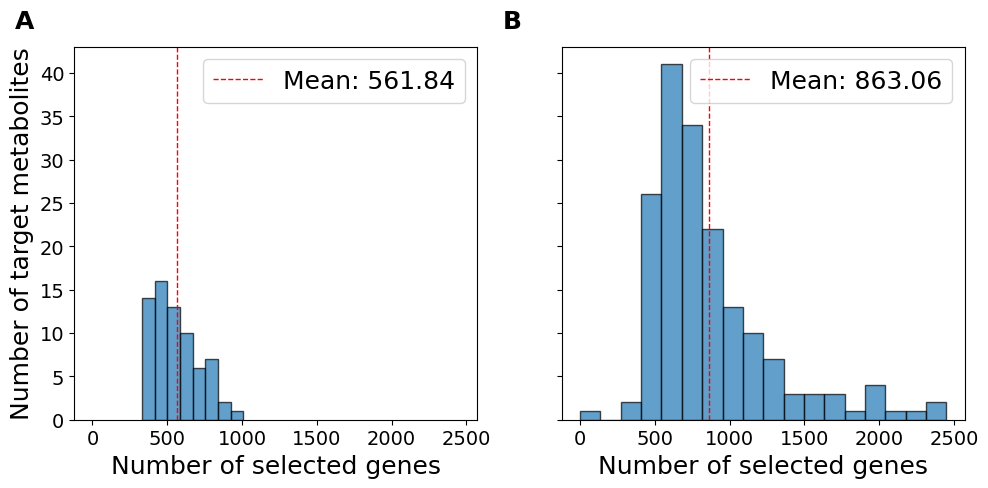

In [31]:
plot_histograms(gcms_feat, lcms_feat, xlabel='Number of selected genes')

Average bin size for GCMS features: 1.8888888888888888
Average bin size for LCMS features: 3.142857142857143


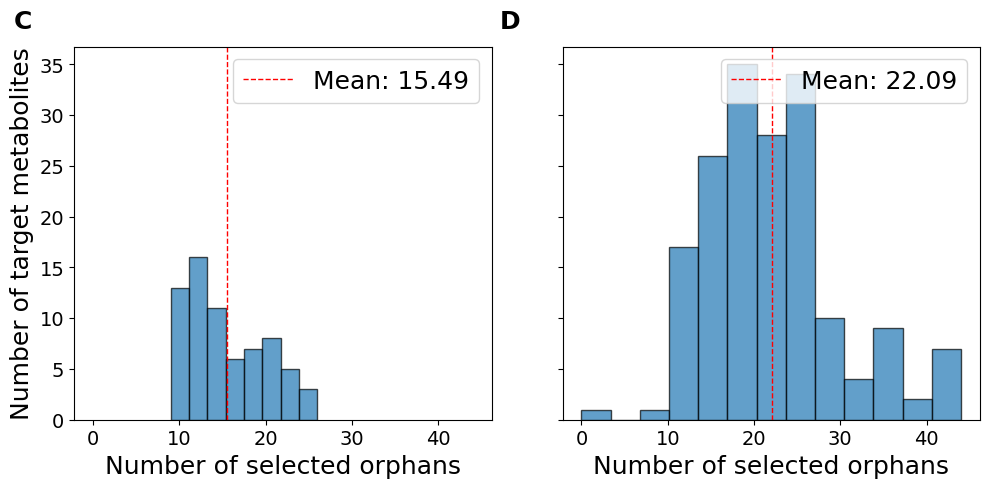

In [32]:
plot_histograms(gcms_orph, lcms_orph, ['C','D'])


## for R^2 > 0.5 GC vs. LC-MS

In [33]:
path_gc = "/home/t44p/PW_rawdata/results/full_lasso/gcms/"
path_lc = "/home/t44p/PW_rawdata/results/full_lasso/lcms/"

lasso_mean10xbg0_5_feat, lasso_mean10xbg0_5_orphans = process_lasso_features(path_gc, path_lc, orphans, mean_10x=0.5)



gcms
Cellobiose_361_204_rt14_40,0.5092822989739512
threonic_acid_292_220_rt7_49,0.8318501827020556
raffinose_437_451_rt16_91,0.8400860515707356
adenosine_5_monophosphate_169_,0.6068794587756502
glucose_160_rt9_81,0.7193264125237092
sucrose_437_361_rt13_77,0.5677346486065996
hexose_307_217_rt9_58,0.526443217562678
citric_acid_273_375_rt9_72,0.5269771663041226
alanine_116_218_rt3_38,0.5958738380483474
glucose_1_phosphate_217_rt9_16,0.5903325634032592
leucine_158_232_rt4_97,0.5334673019388747
valine_144_218_rt4_42,0.6079509868073986
dopamine_174_426_rt11_11,0.5062546026243142
glucose_160_319_rt9_68,0.6757558706387998
erythronic_acid_292_rt7_24,0.7854163354392449
pyroglutamic_acid_156_258_rt8_,0.8135554217259244
aspartic_acid_232_218_rt7_48,0.7188951633039672
inositol_1_phosphate_myo_299_3,0.6402706182219675
Cellobiose_361_204_or_maltose_,0.775732861574897
urea_189_204_rt5_56,0.6765406803989281
glyceric_acid_292_189_rt5_63,0.7773977786942989
quinic_acid_3_caffeoyl_trans_3,0.594100847425184

In [34]:
#list with number of features for each target gcms and lcms. 
gcms_mean10xbg0_5_feat = [len(lasso_mean10xbg0_5_feat['gcms'][target]) for target in lasso_mean10xbg0_5_feat['gcms'].keys()]
print(f"{len(gcms_mean10xbg0_5_feat)}")
lcms_mean10xbg0_5_feat = [len(lasso_mean10xbg0_5_feat['lcms'][target]) for target in lasso_mean10xbg0_5_feat['lcms'].keys()]
print(f"{len(lcms_mean10xbg0_5_feat)}")

#list with number of orphans for each target gcms and lcms. 
gcms_mean10xbg0_5_orph = [len(lasso_mean10xbg0_5_orphans['gcms'][target]) for target in lasso_mean10xbg0_5_orphans['gcms'].keys()]
lcms_mean10xbg0_5_orph = [len(lasso_mean10xbg0_5_orphans['lcms'][target]) for target in lasso_mean10xbg0_5_orphans['lcms'].keys()]


23
57


Average bin size for GCMS features: 71.57142857142857
Average bin size for LCMS features: 154.75


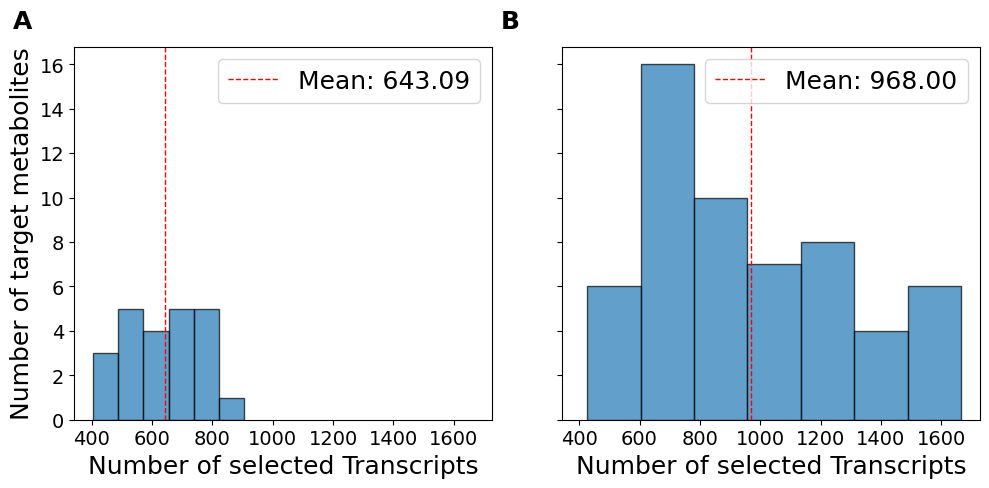

In [35]:
plot_histograms(gcms_mean10xbg0_5_feat, lcms_mean10xbg0_5_feat, xlabel='Number of selected Transcripts')

Average bin size for GCMS features: 2.0
Average bin size for LCMS features: 3.375


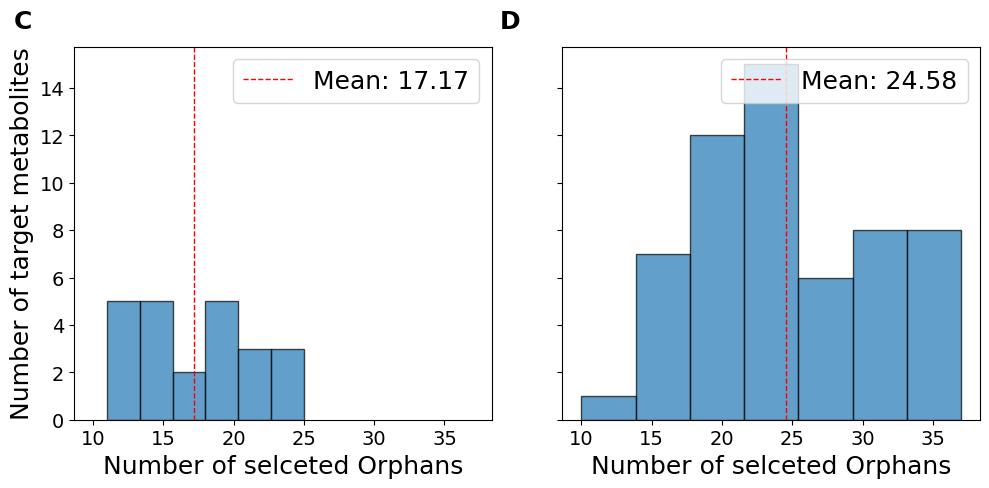

In [36]:
plot_histograms(gcms_mean10xbg0_5_orph, lcms_mean10xbg0_5_orph, ['C','D'], xlabel='Number of selceted Orphans')


## per Group, GC vs. LC-MS

In [37]:
## Here are categories that just have one member, is not suited for pw jaccard, merged them with others below and Rerun for "Other"
# Define the categories
gc_ms_groups = {
    "Sugars_Carbohydrates": [
        "Cellobiose_361_204_rt14_40", 
        "raffinose_437_451_rt16_91", 
        "glucose_160_rt9_81", 
        "inositol_myo_305_265_rt10_71", 
        "sucrose_437_361_rt13_77", 
        "hexose_307_217_rt9_58", 
        "glucose_1_phosphate_217_rt9_16", 
        "trehalose_alpha_alpha_191_169_", 
        "fructose_307_217_rt9_48", 
        "glucose_160_319_rt9_68", 
        "galactinol_204_191_rt15_38", 
        "Ribulose_5_phosphate_357_299_1", 
        "glucose_6_phosphate_160_387_rt", 
        "Cellobiose_361_204_or_maltose_", 
        "_6_phospho_gluconate"
    ],
    "Amino_Acids_and_Derivatives": [
        "tyrosine_218_280_rt10_78",
        "serine_204_218_rt5_84", 
        "isoleucin_158_233_rt_5_21", 
        "asparagine_116_188_rt9_00", 
        "ornithine_142_174_rt9_34", 
        "alanine_3_cyano_141_100_rt6_78",
        "arginine_157_256_rt9_92", 
        "threonine_219_291_rt6_01", 
        "tryptophan_202_291_rt12_94", 
        "alanine_116_218_rt3_38", 
        "leucine_158_232_rt4_97", 
        "valine_144_218_rt4_42", 
        "asparagine_188_216_rt7_84", 
        "methionine_176_128_rt7_76", 
        "asparagine_188_216_rt7_45", 
        "lysine_156_174_rt10_07", 
        "glycine_102_147_rt3_70", 
        "aspartic_acid_232_218_rt7_48", 
        "histidine_154_254_rt11_10", 
        "glutamine_156_245_rt9_80", 
        "glycine_174_248_rt_5_31", 
        "homoserine_218_128_rt6_64", 
        "proline_142_130_rt_5_53", 
        "alanine_beta_248_290_rt6_44", 
        "ornithine_142_348_rt8_03"
    ],
    "Nucleotides_and_Derivatives": [
        "adenine_264_279_rt11_12", 
        "adenosine_5_monophosphate_169_"
    ],
    "Organic_Acids": [
        "threonic_acid_292_220_rt7_49", 
        "citric_acid_273_375_rt9_72", 
        "quinic_acid_255_345_rt9_45", 
        "Oxalic_acid_219_147_3_94", 
        "dehydroascorbic_acid_316_173_r", 
        "erythronic_acid_292_rt7_24", 
        "pyroglutamic_acid_156_258_rt8_", 
        "nonanoic_acid_117_215_rt6_19", 
        "malic_acid_233_245_rt7_22", 
        "glyceric_acid_292_189_rt5_63", 
        "butyric_acid_4_amino_174_304_r", 
        "quinic_acid_3_caffeoyl_trans_3", 
        "galactonic_acid_1_4_lacton_217"
    ],
    "Amines_Amides": [
        "dopamine_174_426_rt11_11", 
        "ethanolamine_174_rt4_63", 
        "guanidine_146_171_rt4_33"
    ],
    "Vitamins_and_Cofactors": [
        "nicotinic_acid_180_136_rt6_32", 
        "pantethaine_4_03_220_235"
    ],
   "Others_merged": [
        "phosphoric_acid_314_299_rt_5_4",
        "glycerol_117_205_rt4_75",
        "pyridine_2_hydroxy_152_167_rt3", 
        "inositol_1_phosphate_myo_299_3", 
        "urea_189_204_rt5_56", 
        "glycerol_3_phosphate_357_445_r", 
        "Hydroxylamine_133_3_07_No_need", 
        "glutamic_acid_246_363_rt8_31",
        "beta_Sitosterol_1TMS_129_18_44"
    ]
}
#lcms_cat = {
#    "lcms": []
#}
#lcms_cat['lcms'] = list(lcms_orph.keys())
## Here are categories that just have one member, is not suited for pw jaccard, merged them with others below and Rerun for "Other"

lc_ms_groups = {
    "Amino_Acids_and_Derivatives": [
        "Argininosuccinic_acid_L", "Aspartyphenylalanine_1_L", "gamma_Glutamylisoleucine_", 
        "gamma_Glutamylvaline_", "Glycyl_L_phenylalanine_L", "Histidine_L", 
        "L_gamma_glutamyl_L_isoleucine", "N_gamma_L_Glutamyl_L_methionin", "Phenylalanylglutamic_acid_", 
        "Prolylglycine_L", "Prolyphenylalanine_or_Leucymet", "Tyrosine_L", "Kynurenine_free_base_L", "N_Decanoylglycine_",
        "Phenylalanyaspartatic_acid_L"
    ],
    "Quinic_Acid_Derivatives": [
        "_3_5_dicaffeoul_quinic_acid_L", "_1_3_Dicaffeoylquinic_acid_", "_4_O_p_Coumaroylquinic_acid_", 
        "_4_5_Di_O_caffeoylquinic_acid_", "Coumaroyl_quinic_acid_", "Caffeoylshikimic_acid_L","Quinic_acid_161_05_", 
        "Quinic_acid_derivative_3_56", "Quinic_acid_derivative_with_he"
    ],
    "Phenolic_Compounds": [
        "Caffeic_acid_1_L", "Caffeic_acid_glucoside_L", "Caffeoylglucarate_L", 
        "Chlorogenic_acid_", "Conduritol_B_Epoxide_L", "Dehydro_Ascorbic_acid_L", "Ferulic_acid_4_O_glucuronide_L", 
        "Feruloyl_di_glucoside_L", "Feruloylglucose_L", "Flavonoid_glycoside_", "Galloylglucose_L", 
        "Gentesic_acid_glucoside_L", "Kaempferol_3_O_glucoside_7_O_r", "Kaempferol_3_O_rhamnoside_7_O_", 
        "Kaempferol_3_O_rutinoside_", "Kaempferol_7_3G_glucosylgentio", "Kaempferol_7_O_Glucoside_1_L", 
        "Kaempferol_glucose_xylose_L", "Kaempferol_rhamnose_glucose", "Naringenin_chalcone_L", "p_coumaroyl_di_glucoside_L", 
        "p_coumaroyl_glucoside_L", "Phenolic_glycoside_", "Quercetin_3_7_di_glucoside_", "Quercetin_3_glucoside_3", 
        "Quercetin_7_4_O_diglucoside_", "Quercetin_glc_glc_rha", "Quercetin_glucose_glucose_rham", 
        "Quercetin_glucose", "Quercetin_glucose_xylose", "Quercitin_3_7_diglucoside_6_rh", "Quercitin_3_O_Glucoside_2_L", 
        "Resveratrol_3_4_diglucoside_L", "Sinapoylglucose_2_L", "Sinapoylglucose_L","Catechol_", "_5_Chlorogenic_acid", "chlorgenic_acid_L", 
        "hydroxyjasmonic_acid_glucoside", "Hydroxy_jasmonic_acid_glucosid"
    ],
    "Sugars_and_Sugar_Derivatives": [
        "alpha_D_Galacturonic_acid_1_ph", "alpha_L_Fucose_1_Phosphate", "Dihydrophaseic_acid_glucoside_", 
        "Dihydroxyacetone_phosphate_L", "Fructose_1_6_biosphasphate_L", "Glucaric_acid_1_4_lactone_L", 
        "Gluconic_acid_lactone_L", "Gluconic_acid_L", "Glutamic_acid_L", "Inosine_L", "Isorhamnetin_3_O_glucoside_L", 
        "Isorhamnetin_3_O_rutinoside", "Lactobionic_acid_L", "Maltotriose_", "naringenin_7_O_glucoside_1_L", 
        "naringenin_7_O_glucoside_3_L", "Pantothenic_acid_L", "Phaseoloidin", 
        "Pyroglutamic_acid_3_L", "Ribulose_5_phosphate_L", "Tartaric_acid_L", "Trehalose", 
        "Trehalose_phenolic_acid_", "Vanilloloside", "Vanilloside_L", "Zeatin_glucoside_L", "_1_O_Feruloyl_glucose_L"
    ],
    "Nucleotides_and_Derivatives": [
        "_5_Deoxy_5_Methylthioadenosine", "Guanosine_", "Nicotinamide_adenine_dinucleot", 
        "Oxidized_glutathione_",
    ],
    "Terpenes_and_Triterpenes": [
        "Diterpene_8_2", "Terpene_10_26", "Terpene_9_53", "Triterpene_10_43", "Triterpene_10_78", 
        "Triterpene_8_14", "Triterpene_8_21", "Triterpene_9_79"
    ],
    "Saponins": [
        "Saponin_10_182", "Saponin_10_183", "Saponin_10_264", "Saponin_10_47", "Saponin_10_56", 
        "Saponin_10_67780171", "Saponin_10_72", "Saponin_8_02", "Saponin_8_42", "Saponin_8_83", 
        "Saponin_8_8", "Saponin_9_18", "Saponin_9_88", "Soyasaponin_A2_L"
    ],
    "Other_merged": [
            "_10_Formyltetrahydrofolate_L", "_3_Deoxy_D_manno_2_octulosonic", "_5_hydroxy_Ferulic_acid_Glucos2", 
            "_5_hydroxy_ferulic_acid_glucos", "_6_phosphogluconic_acid_L", "_7_Epi_12_hydroxyjasmonic_acid", 
            "_D_Glycero_alpha_D_Manno_Hepto", "_R_2_Phenylglycin", "Azelaic_acid_L", "Azukisaponin_VI_1_L", 
            "CGA_hexose_", "Urocanic_acid_L","_Rutin", "porphobilinogen_2_L"
    ],
    "unidentified": [
        "_1021_486521_9_141280832",
        "_1021_48667462_9_66538870707",
        "_1063_497231_10_58247297",
        "_1063_529871_9_415000766",
        "_1141_528589_8_043846139",
        "_1151_551493_10_40677464",
        "_1165_527084_8_995631942",
        "_1183_537778_8_600427106",
        "_1183_538043_8_673358308",
        "_1191_542641_10_3213884",
        "_1209_556345_10_14653119",
        "_1241_580464_8_916526509",
        "_1253_57885907_8_99579782362",
        "_1283_593009_9_259004534",
        "_1283_593348_9_160768845",
        "_1313_601235_9_01121774",
        "_303_0720727_3_335904942",
        "_312_0943959_2_614228811",
        "_351_1294837_5_809380415",
        "_366_9939681_1_170199352",
        "_374_1568694_3_674168475",
        "_380_1288743_6_36896135",
        "_427_1824019_5_95992104",
        "_429_1765684_7_873841266",
        "_441_1978503_6_218123415",
        "_475_1821542_6_560220101",
        "_487_2029578_5_338775921",
        "_496_1502126_3_792994891",
        "_512_1445532_3_132648409",
        "_523_1663837_5_238225973",
        "_531_2448764_7_209307815",
        "_567_2828405_6_133036019",
        "_641_171822_6_885700966",
        "_658_1575839_4_528042834",
        "_671_2775803_7_254060113",
        "_821_3258533_9_228249892",
        "_857_418157679_9_32212355859",
        "_857_418693067_9_24167206032",
        "_931_4518066_8_63280459",
        "_933_4699157_8_265868462",
        "_947_486080952_9_72692719903",
        "_963_4798371_8_624190173",
        "_987_4809544_10_24318525"
    ]
}


In [38]:
def process_per_category(categories, path, orphans, mean_10x=None):
    """
    For each category in the categories dict, extract info and organize into a new dictionary.
    
    Args:
        categories (dict): A dictionary where keys are category names and values are lists of items/metabolites in that category.
        keys (list): A list of keys to generate values for each item/metabolite in the categories.


        
    Returns:
        dict: A nested dictionary organized by category, then items/metabolites, each containing generated values for the specified keys.
    """
    result_dict = {} 
    result_orphans = {}
    c = 0
    d = 0
    for cat, metabolites in categories.items():
        result_dict[cat] = {}
        result_orphans[cat] = {}

        for metabolite in metabolites:
            result_dict[cat][metabolite] = {}
            result_orphans[cat][metabolite] = {}

            file_path = os.path.join(path, f"{metabolite}_nXcv.json")
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)

            if mean_10x != None:
                if mean_10x > data['best_param'][-1]:
                    #print(f"{target} mean10x: {data['best_param'][-1]}")
                    d += 1
                    continue

            if not data['selected_features']:
                c += 1
                print(f"{cat} target w/o features: {metabolite}")
            
            result_dict[cat][metabolite] = data['selected_features']

            # extracting orphans
            feat = set(data['selected_features'])
            orph_feat = feat.intersection(set(orphans))
            result_orphans[cat][metabolite] = list(orph_feat)
            #all_orph[p_key].extend(list(orph_feat))
            
    return result_dict, result_orphans

In [39]:
def plot_grid_subplots(gcms_results_by_group, bin_number='auto', title=True, x_label='Number of selected features', y_label='Number of target metabolites'):
    # Determine the grid size
    n_categories = len(gcms_results_by_group)
    grid_size = math.ceil(math.sqrt(n_categories))  # Square root to determine grid size, rounded up
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15), sharex=True, sharey=True)
    axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate over it

    # A to Z depends on the number of keys in gcms_results by group
    descriptions = [chr(i) for i in range(65, 65+len(gcms_results_by_group.keys()))]
    

    for ax, desc, (cat, metabolites) in zip(axs, descriptions, gcms_results_by_group.items()):
        # Extract mean_10x values for all metabolites in the category, applying threshold if provided
        #number_features = [info['mean_10x'] for metabolite, info in metabolites.items() if (gt_tresh is None or info['mean_10x'] > gt_tresh)]
        number_features = [len(info) for metabolite, info in metabolites.items()]
        print(f"({desc}) {cat}: \n{number_features}")
        #continue
        # Calculate bins
        print(f"{cat}")        
        bin_edges = np.histogram_bin_edges(number_features, bins=bin_number)
        bin_sizes = np.diff(bin_edges)  # Calculate the bin sizes
        print("Bin sizes:", bin_sizes)
        average_bin_size = np.mean(bin_sizes)
        print("Average bin size:", average_bin_size)

        # Calculate the median for the mean_10x values, handling empty lists due to threshold
        median_value = np.median(number_features) if number_features else 0

        # Plot histogram of mean_10x values if there are any values to plot after threshold filtering
        if number_features:
            ax.hist(number_features, bins=bin_edges, color='C0', edgecolor='black')
            # Mark the median with a red dashed line
            ax.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.2f}')
            ax.text(-0.1, 1.1, desc, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

        else:
            ax.text(0.5, 0.5, 'No data above threshold', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.text(-0.1, 1.1, desc, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

        # add numbers to every x-axis
        ax.xaxis.set_tick_params(labelbottom=True)

        # Set the title and labels
        if title:
            ax.set_title(f'{cat}')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend()

    # Hide unused subplots if any
    for i in range(n_categories, grid_size**2):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

### all nevermind the R^2

In [40]:
gcms_cat_feat, gcms_cat_orph = process_per_category(gc_ms_groups, path=path_gc, orphans=orphans)
lcms_cat_feat, lcms_cat_orph = process_per_category(lc_ms_groups, path=path_lc, orphans=orphans)


Amino_Acids_and_Derivatives target w/o features: Argininosuccinic_acid_L


(A) Sugars_Carbohydrates: 
[405, 906, 615, 461, 462, 552, 697, 592, 1009, 773, 492, 408, 449, 537, 581]
Sugars_Carbohydrates
Bin sizes: [60.4 60.4 60.4 60.4 60.4 60.4 60.4 60.4 60.4 60.4]
Average bin size: 60.4
(B) Amino_Acids_and_Derivatives: 
[608, 475, 596, 351, 437, 436, 361, 502, 650, 782, 642, 551, 407, 415, 569, 356, 882, 495, 369, 657, 469, 446, 648, 447, 837]
Amino_Acids_and_Derivatives
Bin sizes: [53.1 53.1 53.1 53.1 53.1 53.1 53.1 53.1 53.1 53.1]
Average bin size: 53.1
(C) Nucleotides_and_Derivatives: 
[817, 551]
Nucleotides_and_Derivatives
Bin sizes: [26.6 26.6 26.6 26.6 26.6 26.6 26.6 26.6 26.6 26.6]
Average bin size: 26.6
(D) Organic_Acids: 
[814, 735, 538, 524, 571, 686, 585, 332, 385, 770, 630, 773, 457]
Organic_Acids
Bin sizes: [48.2 48.2 48.2 48.2 48.2 48.2 48.2 48.2 48.2 48.2]
Average bin size: 48.2
(E) Amines_Amides: 
[676, 469, 440]
Amines_Amides
Bin sizes: [23.6 23.6 23.6 23.6 23.6 23.6 23.6 23.6 23.6 23.6]
Average bin size: 23.6
(F) Vitamins_and_Cofactors: 
[386,

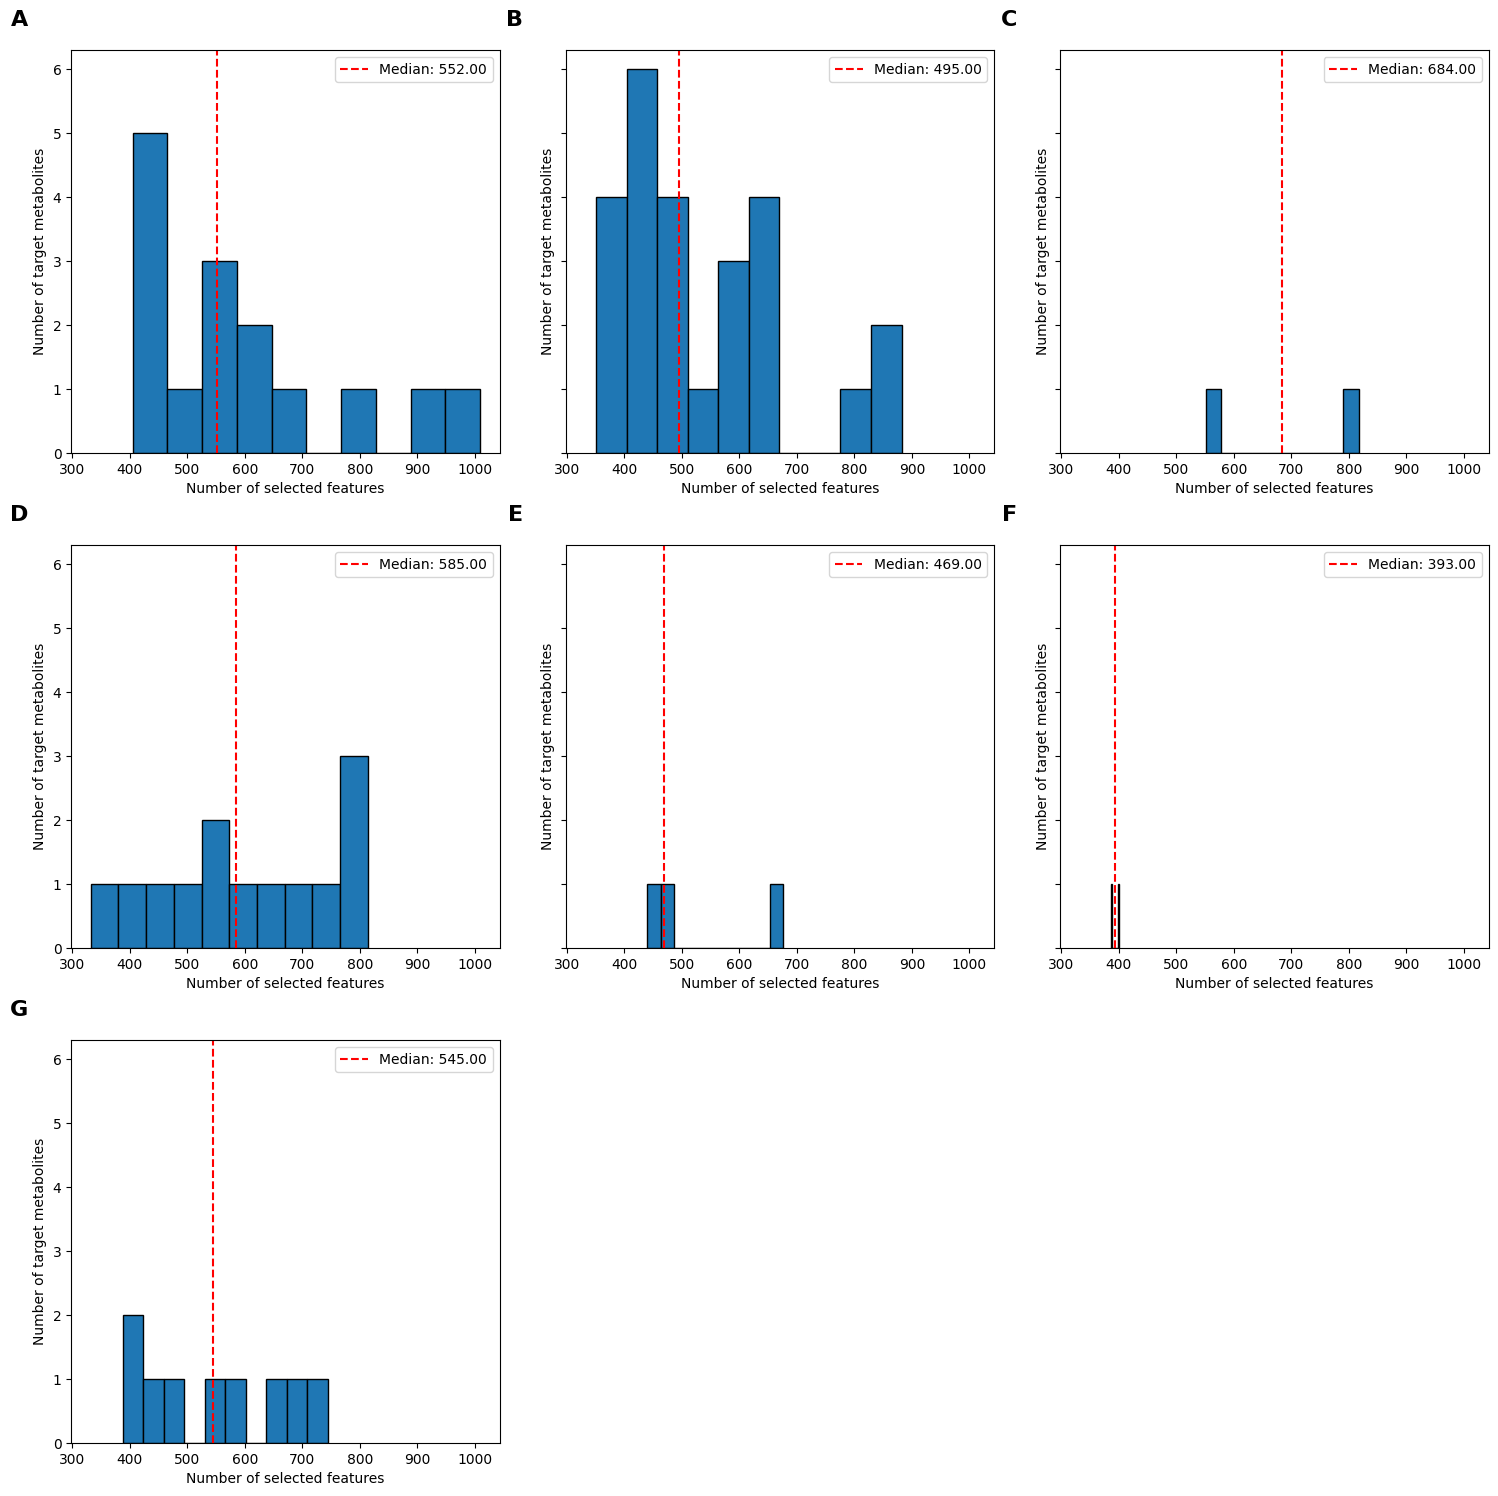

In [41]:
plot_grid_subplots(gcms_cat_feat, bin_number=10, title=False)

(A) Amino_Acids_and_Derivatives: 
[0, 625, 426, 718, 503, 526, 594, 653, 1295, 2396, 650, 1518, 1051, 722, 632]
Amino_Acids_and_Derivatives
Bin sizes: [239.6 239.6 239.6 239.6 239.6 239.6 239.6 239.6 239.6 239.6]
Average bin size: 239.6
(B) Quinic_Acid_Derivatives: 
[545, 833, 803, 918, 563, 598, 583, 1737, 836]
Quinic_Acid_Derivatives
Bin sizes: [119.2 119.2 119.2 119.2 119.2 119.2 119.2 119.2 119.2 119.2]
Average bin size: 119.2
(C) Phenolic_Compounds: 
[1051, 1243, 701, 976, 866, 1202, 1002, 949, 838, 761, 886, 919, 1639, 1190, 810, 2255, 710, 970, 679, 900, 1354, 1482, 628, 1665, 996, 1223, 646, 2450, 1326, 797, 888, 1264, 793, 1477, 552, 609, 667, 1163, 1096, 728]
Phenolic_Compounds
Bin sizes: [189.8 189.8 189.8 189.8 189.8 189.8 189.8 189.8 189.8 189.8]
Average bin size: 189.8
(D) Sugars_and_Sugar_Derivatives: 
[1180, 585, 604, 563, 609, 687, 659, 510, 1992, 1296, 1225, 935, 692, 775, 1596, 658, 743, 694, 625, 1035, 801, 427, 544, 665, 988, 698, 1212]
Sugars_and_Sugar_Derivatives

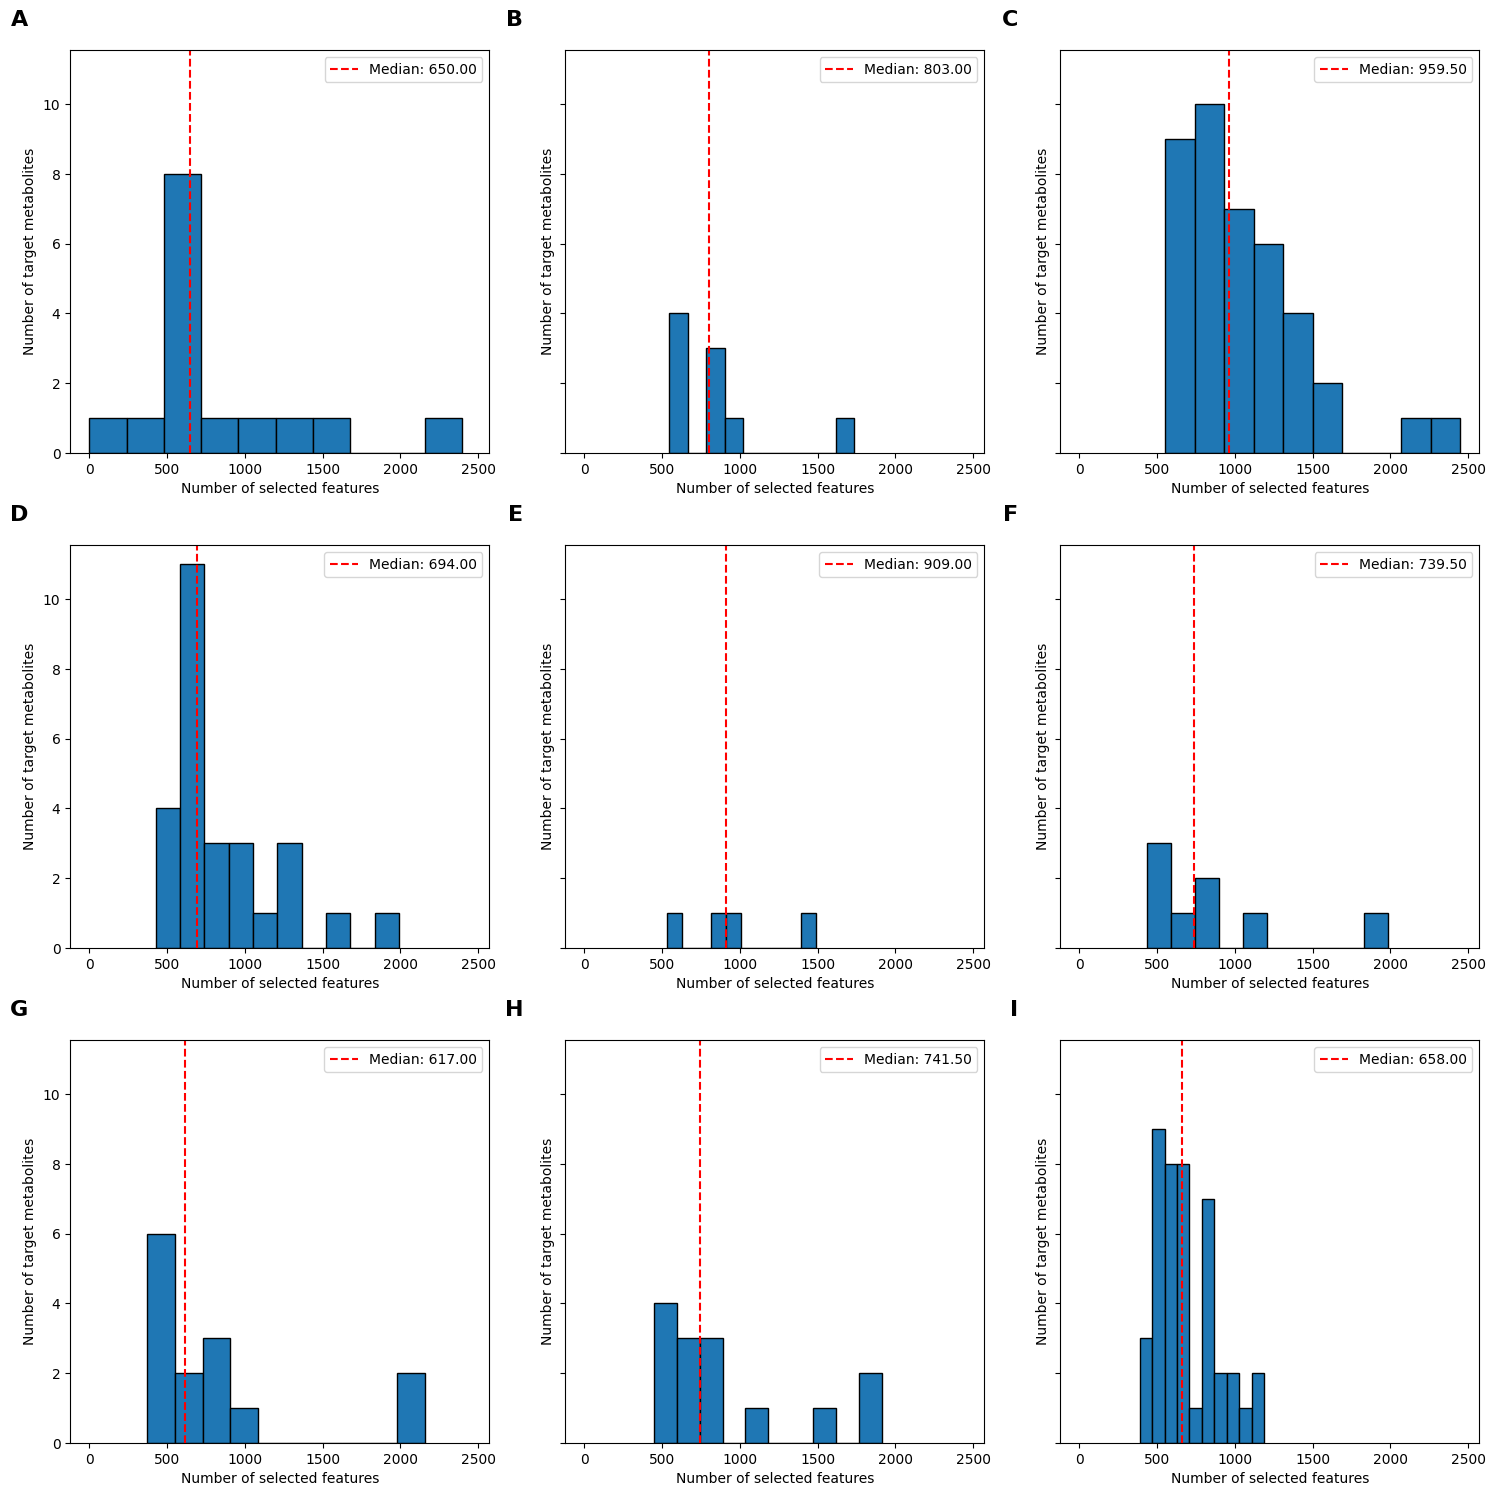

In [42]:
plot_grid_subplots(lcms_cat_feat, bin_number=10,title=False)


In [43]:
gcms_cat_orph['Sugars_Carbohydrates']['fructose_307_217_rt9_48']

['Xele.ptg000037l.72',
 'Xele.ptg000001l.570',
 'Xele.ptg000021l.326',
 'Xele.ptg000026l.197',
 'Xele.ptg000028l.256',
 'Xele.ptg000025l.147',
 'Xele.ptg000022l.159',
 'Xele.ptg000044l.541',
 'Xele.ptg000012l.46',
 'Xele.ptg000032l.128',
 'Xele.ptg000013l.967',
 'Xele.ptg000011l.460',
 'Xele.ptg000018l.1926',
 'Xele.ptg000003l.1122',
 'Xele.ptg000006l.390',
 'Xele.ptg000018l.2167',
 'Xele.ptg000006l.731',
 'Xele.ptg000067l.225',
 'Xele.ptg000007l.419',
 'Xele.ptg000022l.1389',
 'Xele.ptg000020l.304',
 'Xele.ptg000067l.224',
 'Xele.ptg000023l.532',
 'Xele.ptg000044l.551',
 'Xele.ptg000005l.538']

In [88]:
def plot_grouped_bars(data_dict,fontsize=14, labelsize=12):
    cat_names = []
    total_counts = []
    unique_counts = []
    averages = []
    intersection_count = []

    # Process each category in the nested dictionary
    for cat, inner_dict in data_dict.items():
        cat_names.append(cat)
        gene_ids = [item for sublist in inner_dict.values() for item in sublist]
        total_counts.append(len(gene_ids))

        # unique IDs by removing any IDs that appear in other categories
        # outer loop: for each cat and its inner dict: for each cat no current take all ids, for all ids within each dict entry, place in set == uniq ids
        unique_gene_ids = set(gene_ids) - set([item for g, i_d in data_dict.items() if g != cat for sublist in i_d.values() for item in sublist])
        print(f"{cat},{unique_gene_ids}")
        unique_counts.append(len(unique_gene_ids))
        print(f"Unique counts for {cat}: {len(unique_gene_ids)}")

        # Count the number of gene IDs that are shared within the group
        shared_count = 0
        for key, ids in inner_dict.items():
            for id in ids:
                if sum([id in sublist for sublist in inner_dict.values()]) > 1:
                    shared_count += 1
        intersection_count.append(shared_count // 2)  # Dividing by 2 to correct for double-counting

        averages.append(len(gene_ids) / len(inner_dict) if inner_dict else 0)

    # Creating the bar plot
    fig, ax = plt.subplots()
    bars = ax.barh(cat_names, total_counts, alpha=0.7, label='Total in group')

    # Adding the unique count part to the bars
    #for i, bar in enumerate(bars):
    #    ax.barh(bar.get_y(), unique_counts[i], height=bar.get_height(), color='red', alpha=0.7, label='Unique to group' if i == 0 else "")

    # Adding the intersection count part to the bars
    for i, bar in enumerate(bars):
        ax.barh(bar.get_y(), intersection_count[i], height=bar.get_height(), color='salmon', alpha=0.7, label='Shared within group' if i == 0 else "")

    # Adding average count as text
    pos = max(total_counts) / 2  #centered horizontally
    #pos = min(total_counts) + 70
    for i, bar in enumerate(bars):
        #ax.text(pos, bar.get_y() + bar.get_height() / 2, f'uniq: {unique_counts[i]}', ha='center', va='center', color='black', fontweight='bold')
        ax.text(pos, bar.get_y() + bar.get_height() / 2, f'uniq: {unique_counts[i]}', ha='center', va='center', color='black', fontweight='bold', fontsize=fontsize)

    ax.set_xlabel('Number of selected orphans')
    #ax.set_ylabel('Groups')
    ax.set_xlabel('Number of selected orphans', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    #ax.set_title('Grouped Identifier Counts with Unique and Shared Counts Highlighted')
     # Place the legend outside the plot
    ax.legend(fontsize=fontsize, bbox_to_anchor=(1.05, 1), loc='upper center')
    #plt.tight_layout()
    plt.show()


Sugars_Carbohydrates,{'Xele.ptg000021l.326'}
Unique counts for Sugars_Carbohydrates: 1
Amino_Acids_and_Derivatives,{'Xele.ptg000018l.1853'}
Unique counts for Amino_Acids_and_Derivatives: 1
Nucleotides_and_Derivatives,{'Xele.ptg000025l.300', 'Xele.ptg000049l.220'}
Unique counts for Nucleotides_and_Derivatives: 2
Organic_Acids,set()
Unique counts for Organic_Acids: 0
Amines_Amides,{'Xele.ptg000022l.856'}
Unique counts for Amines_Amides: 1
Vitamins_and_Cofactors,set()
Unique counts for Vitamins_and_Cofactors: 0
Others_merged,set()
Unique counts for Others_merged: 0


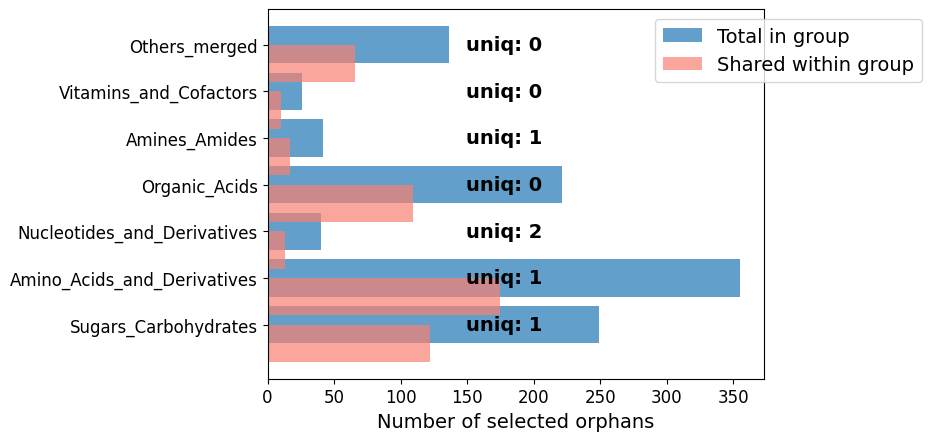

In [89]:
plot_grouped_bars(gcms_cat_orph)

Amino_Acids_and_Derivatives,{'Xele.ptg000022l.1060', 'Xele.ptg000034l.89'}
Unique counts for Amino_Acids_and_Derivatives: 2
Quinic_Acid_Derivatives,set()
Unique counts for Quinic_Acid_Derivatives: 0
Phenolic_Compounds,{'Xele.ptg000003l.1022', 'Xele.ptg000016l.152', 'Xele.ptg000012l.654', 'Xele.ptg000020l.534'}
Unique counts for Phenolic_Compounds: 4
Sugars_and_Sugar_Derivatives,set()
Unique counts for Sugars_and_Sugar_Derivatives: 0
Nucleotides_and_Derivatives,set()
Unique counts for Nucleotides_and_Derivatives: 0
Terpenes_and_Triterpenes,set()
Unique counts for Terpenes_and_Triterpenes: 0
Saponins,{'Xele.ptg000045l.43'}
Unique counts for Saponins: 1
Other_merged,set()
Unique counts for Other_merged: 0
unidentified,set()
Unique counts for unidentified: 0


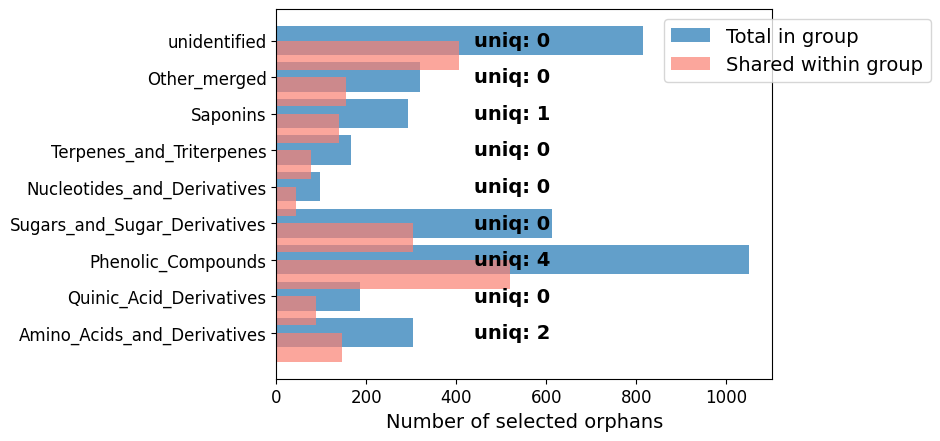

In [90]:
plot_grouped_bars(lcms_cat_orph)



### R^2 > 0.5

In [91]:
gcms_cat_feat_0_5, gcms_cat_orph_0_5 = process_per_category(gc_ms_groups, path=path_gc, orphans=orphans, mean_10x=0.5)
lcms_cat_feat_0_5, lcms_cat_orph_0_5 = process_per_category(lc_ms_groups, path=path_lc, orphans=orphans, mean_10x=0.5)


(A) Sugars_Carbohydrates: 
[405, 906, 615, 0, 462, 552, 697, 0, 0, 773, 0, 0, 0, 537, 0]
Sugars_Carbohydrates
Bin sizes: [90.6 90.6 90.6 90.6 90.6 90.6 90.6 90.6 90.6 90.6]
Average bin size: 90.6
(B) Amino_Acids_and_Derivatives: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 782, 642, 551, 0, 0, 0, 0, 0, 495, 0, 0, 0, 0, 0, 0, 0]
Amino_Acids_and_Derivatives
Bin sizes: [78.2 78.2 78.2 78.2 78.2 78.2 78.2 78.2 78.2 78.2]
Average bin size: 78.2
(C) Nucleotides_and_Derivatives: 
[0, 551]
Nucleotides_and_Derivatives
Bin sizes: [55.1 55.1 55.1 55.1 55.1 55.1 55.1 55.1 55.1 55.1]
Average bin size: 55.1
(D) Organic_Acids: 
[814, 735, 0, 0, 0, 686, 585, 0, 0, 770, 0, 773, 0]
Organic_Acids
Bin sizes: [81.4 81.4 81.4 81.4 81.4 81.4 81.4 81.4 81.4 81.4]
Average bin size: 81.4
(E) Amines_Amides: 
[676, 0, 0]
Amines_Amides
Bin sizes: [67.6 67.6 67.6 67.6 67.6 67.6 67.6 67.6 67.6 67.6]
Average bin size: 67.6
(F) Vitamins_and_Cofactors: 
[0, 0]
Vitamins_and_Cofactors
Bin sizes: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

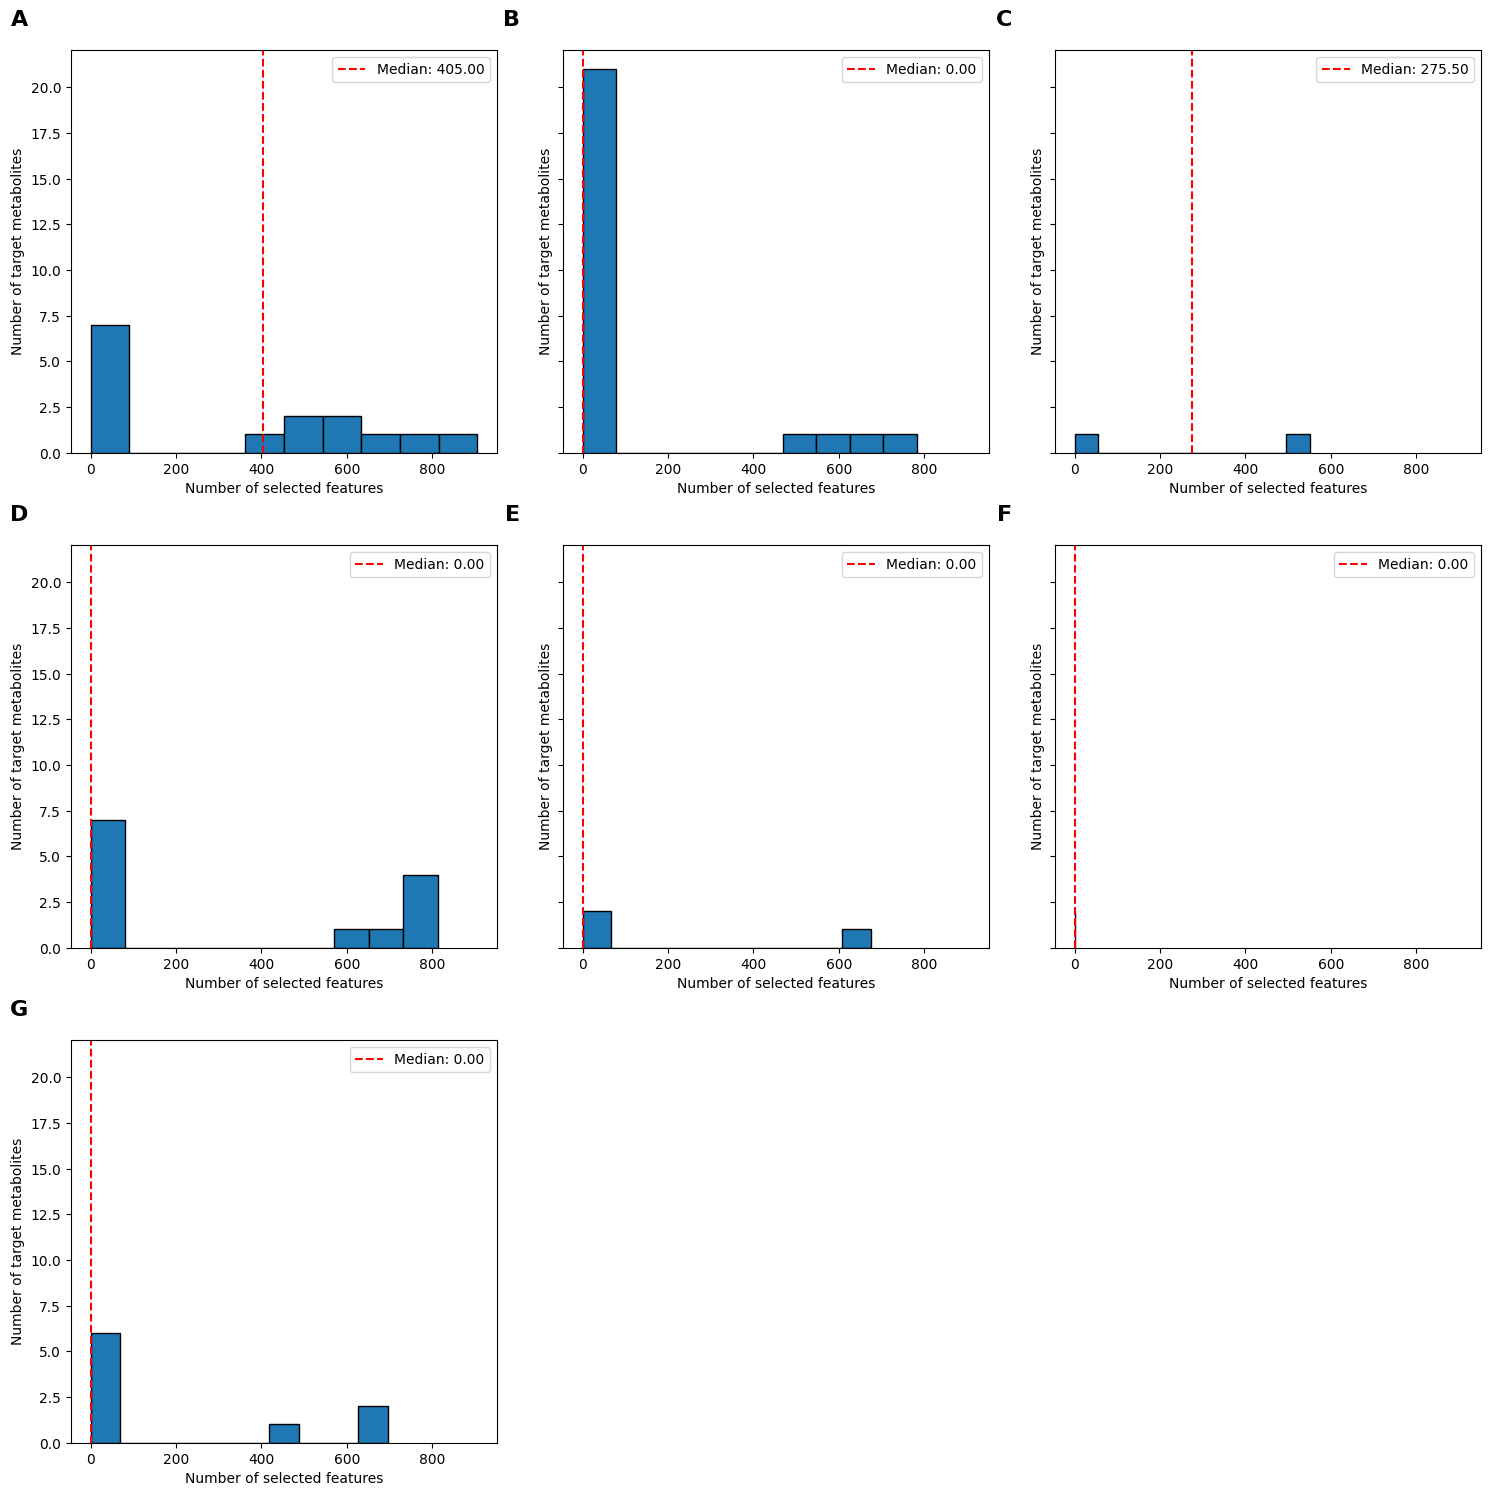

(A) Amino_Acids_and_Derivatives: 
[0, 625, 0, 0, 0, 0, 594, 653, 1295, 0, 0, 1518, 1051, 0, 632]
Amino_Acids_and_Derivatives
Bin sizes: [151.8 151.8 151.8 151.8 151.8 151.8 151.8 151.8 151.8 151.8]
Average bin size: 151.8
(B) Quinic_Acid_Derivatives: 
[0, 0, 803, 0, 0, 598, 0, 0, 0]
Quinic_Acid_Derivatives
Bin sizes: [80.3 80.3 80.3 80.3 80.3 80.3 80.3 80.3 80.3 80.3]
Average bin size: 80.3
(C) Phenolic_Compounds: 
[1051, 1243, 0, 0, 866, 0, 0, 949, 0, 0, 0, 0, 1639, 1190, 810, 0, 710, 970, 679, 900, 1354, 1482, 0, 1665, 996, 1223, 646, 0, 1326, 797, 888, 1264, 0, 1477, 0, 0, 667, 0, 0, 0]
Phenolic_Compounds
Bin sizes: [166.5 166.5 166.5 166.5 166.5 166.5 166.5 166.5 166.5 166.5]
Average bin size: 166.5
(D) Sugars_and_Sugar_Derivatives: 
[0, 585, 0, 0, 0, 0, 0, 0, 0, 1296, 1225, 935, 692, 775, 1596, 0, 743, 0, 0, 0, 0, 427, 544, 0, 0, 698, 1212]
Sugars_and_Sugar_Derivatives
Bin sizes: [159.6 159.6 159.6 159.6 159.6 159.6 159.6 159.6 159.6 159.6]
Average bin size: 159.6
(E) Nucleotides_

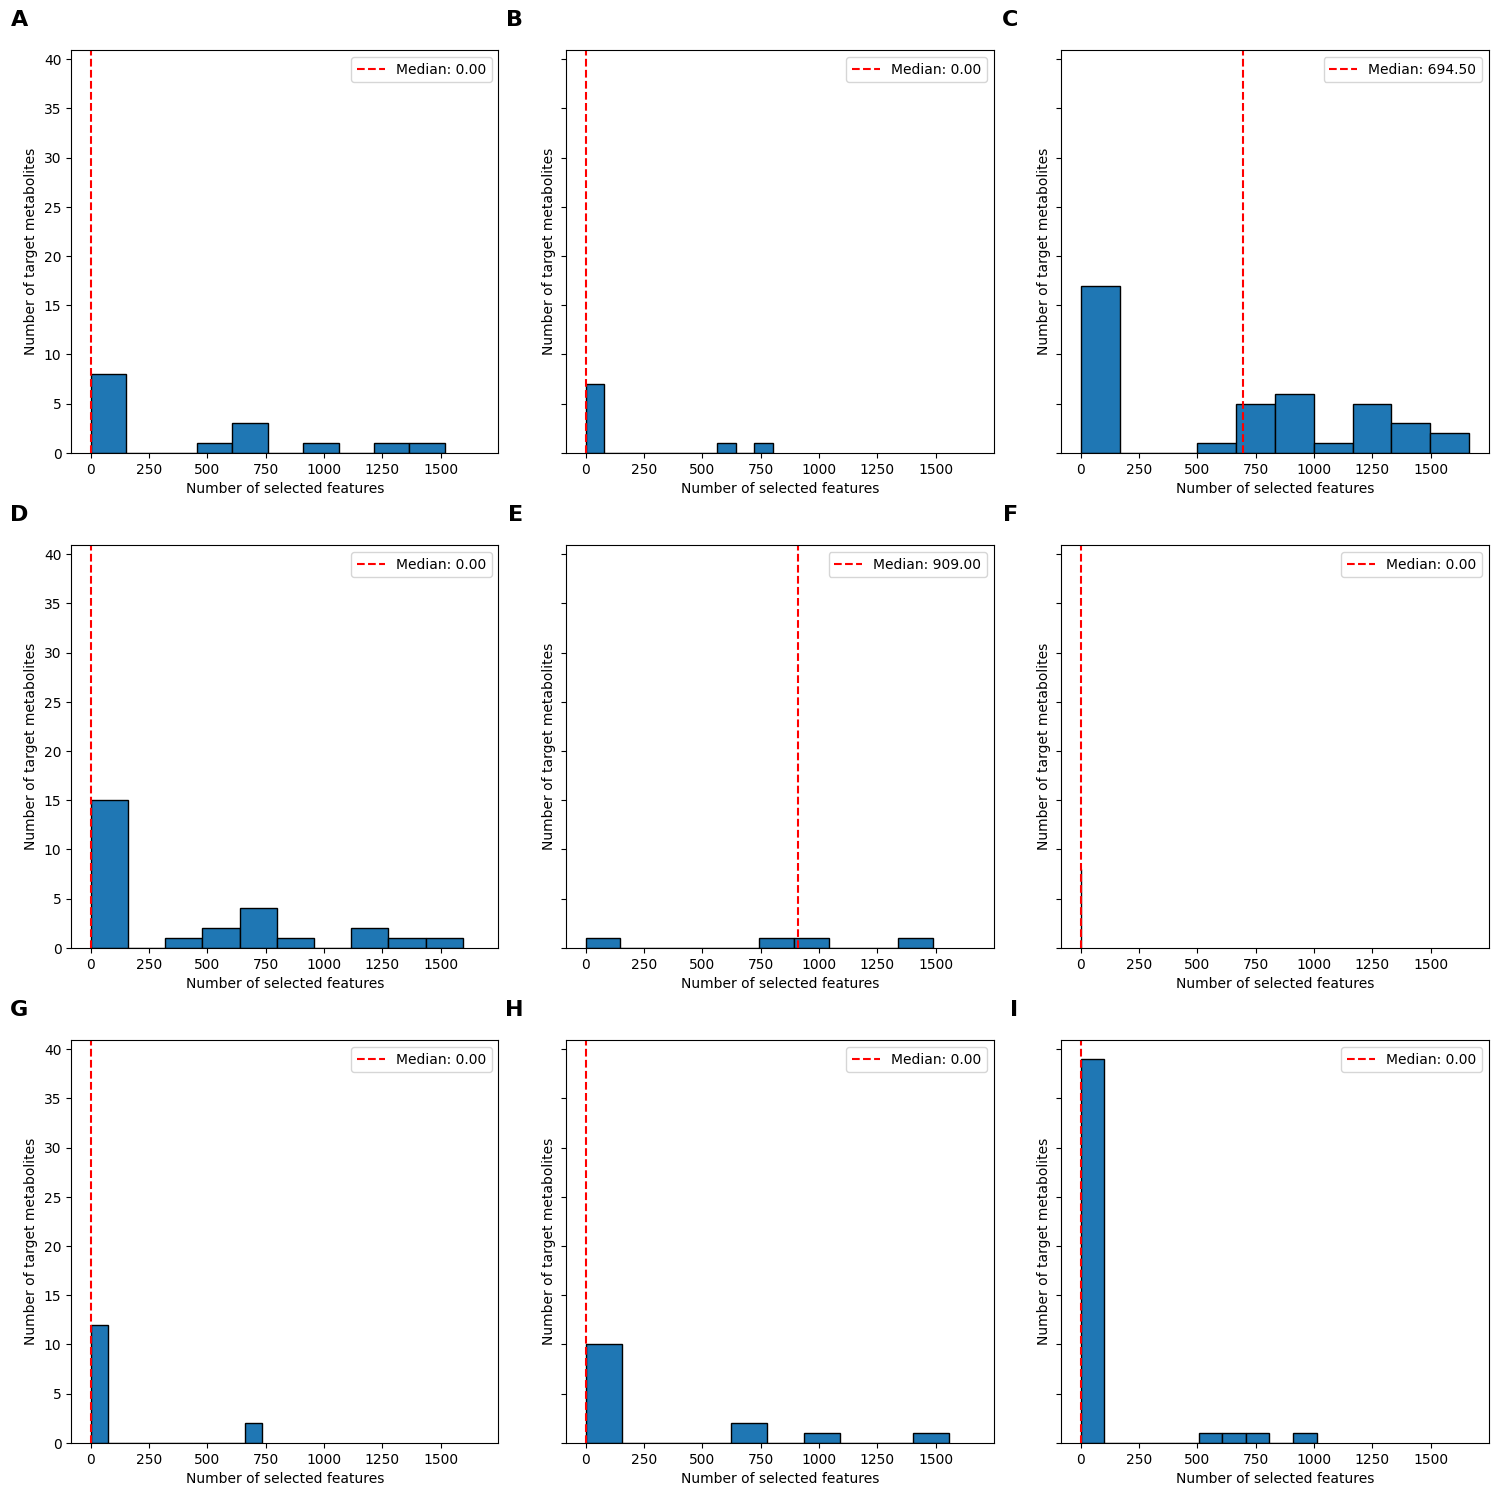

In [92]:
plot_grid_subplots(gcms_cat_feat_0_5, bin_number=10, title=False)
plot_grid_subplots(lcms_cat_feat_0_5, bin_number=10, title=False)


Sugars_Carbohydrates,{'Xele.ptg000035l.204', 'Xele.ptg000020l.304'}
Unique counts for Sugars_Carbohydrates: 2
Amino_Acids_and_Derivatives,{'Xele.ptg000018l.1853'}
Unique counts for Amino_Acids_and_Derivatives: 1
Nucleotides_and_Derivatives,set()
Unique counts for Nucleotides_and_Derivatives: 0
Organic_Acids,{'Xele.ptg000012l.1108'}
Unique counts for Organic_Acids: 1
Amines_Amides,set()
Unique counts for Amines_Amides: 0
Vitamins_and_Cofactors,set()
Unique counts for Vitamins_and_Cofactors: 0
Others_merged,set()
Unique counts for Others_merged: 0


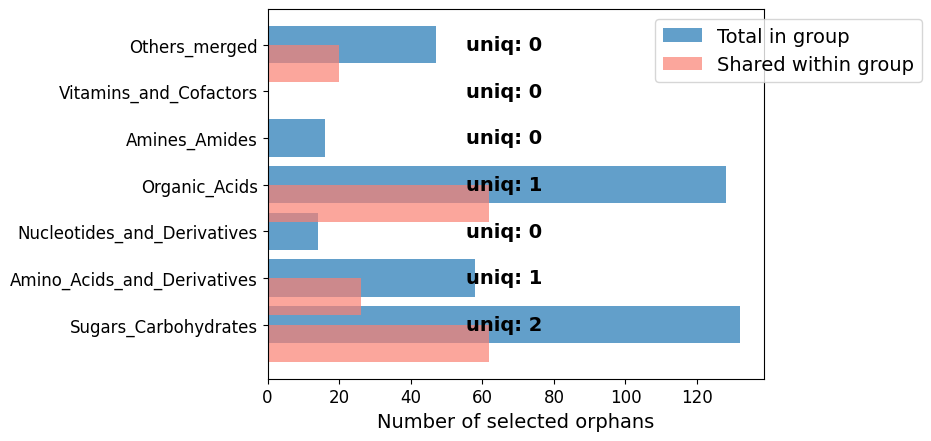

Amino_Acids_and_Derivatives,{'Xele.ptg000018l.677', 'Xele.ptg000034l.80'}
Unique counts for Amino_Acids_and_Derivatives: 2
Quinic_Acid_Derivatives,set()
Unique counts for Quinic_Acid_Derivatives: 0
Phenolic_Compounds,{'Xele.ptg000046l.83', 'Xele.ptg000016l.152', 'Xele.ptg000020l.534', 'Xele.ptg000011l.204', 'Xele.ptg000018l.656'}
Unique counts for Phenolic_Compounds: 5
Sugars_and_Sugar_Derivatives,set()
Unique counts for Sugars_and_Sugar_Derivatives: 0
Nucleotides_and_Derivatives,set()
Unique counts for Nucleotides_and_Derivatives: 0
Terpenes_and_Triterpenes,set()
Unique counts for Terpenes_and_Triterpenes: 0
Saponins,set()
Unique counts for Saponins: 0
Other_merged,set()
Unique counts for Other_merged: 0
unidentified,set()
Unique counts for unidentified: 0


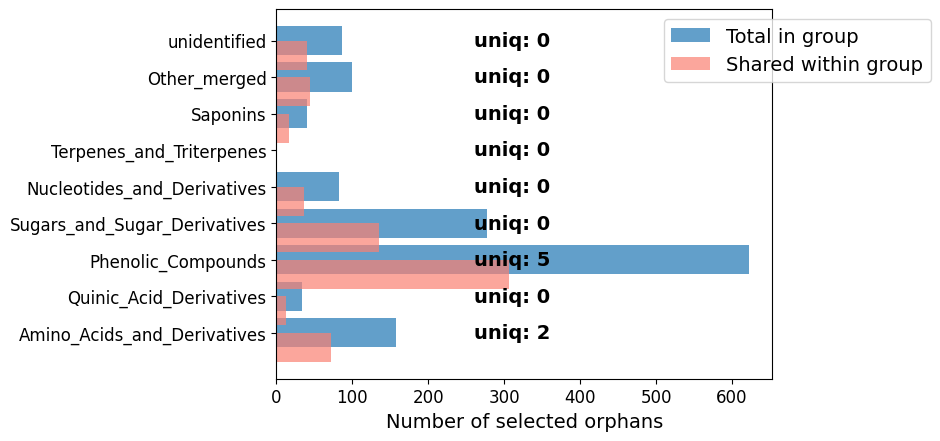

In [93]:
plot_grouped_bars(gcms_cat_orph_0_5)
plot_grouped_bars(lcms_cat_orph_0_5)


# Radnom forest

In [94]:
rfr_gc = '/home/t44p/PW_rawdata/results/test_rfr/gcms'
gcrfr_cat_feat, gcrfr_cat_orph = process_per_category(gc_ms_groups, path=rfr_gc, orphans=orphans, mean_10x=0.5)


Sugars_Carbohydrates,{'Xele.ptg000022l.451', 'Xele.ptg000005l.495', 'Xele.ptg000003l.481', 'Xele.ptg000007l.108', 'Xele.ptg000037l.110', 'Xele.ptg000030l.158', 'Xele.ptg000046l.338', 'Xele.ptg000003l.132', 'Xele.ptg000020l.348', 'Xele.ptg000067l.480', 'Xele.ptg000004l.554', 'Xele.ptg000004l.326', 'Xele.ptg000020l.545', 'Xele.ptg000042l.322', 'Xele.ptg000003l.690', 'Xele.ptg000067l.103', 'Xele.ptg000003l.1267', 'Xele.ptg000059l.33', 'Xele.ptg000038l.328', 'Xele.ptg000026l.277', 'Xele.ptg000013l.967', 'Xele.ptg000038l.478', 'Xele.ptg000043l.727', 'Xele.ptg000009l.356', 'Xele.ptg000041l.127', 'Xele.ptg000003l.1122', 'Xele.ptg000013l.846', 'Xele.ptg000013l.739', 'Xele.ptg000002l.443', 'Xele.ptg000023l.384', 'Xele.ptg000016l.269', 'Xele.ptg000020l.556', 'Xele.ptg000003l.605', 'Xele.ptg000014l.96', 'Xele.ptg000018l.44', 'Xele.ptg000027l.595', 'Xele.ptg000044l.35', 'Xele.ptg000012l.140', 'Xele.ptg000006l.729', 'Xele.ptg000013l.788', 'Xele.ptg000027l.396', 'Xele.ptg000035l.114', 'Xele.ptg00000

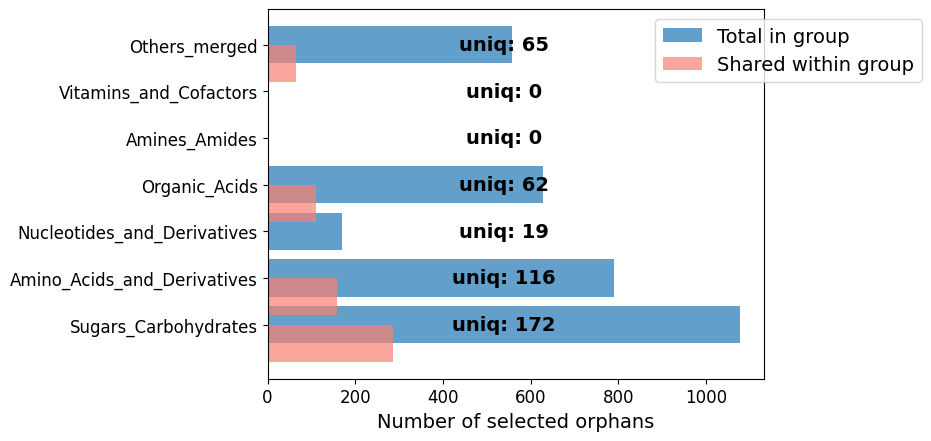

In [95]:
plot_grouped_bars(gcrfr_cat_orph)